# Evaluate classification accuracy

This notebook demonstrates how to evaluate classification accuracy of "cross-validated" simulated communities. Due to the unique nature of this analysis, the metrics that we use to evaluate classification accuracy are different from those used for mock.

The key measure here is rate of ``match`` vs. ``overclassification``, hence P/R/F are not useful metrics. Instead, we define and measure the following as percentages:
* Match vs. overclassification rate
    * Match: exact match at level L
    * underclassification: lineage assignment is correct, but shorter than expected (e.g., not to species level)
    * misclassification: incorrect assignment
    
Where ``L`` = taxonomic level being tested


## Functions

In [1]:
from tax_credit.framework_functions import (novel_taxa_classification_evaluation,
                                            extract_per_level_accuracy)
from tax_credit.eval_framework import parameter_comparisons
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           rank_optimized_method_performance_by_dataset)

import pandas as pd
from os.path import expandvars, join, exists
from glob import glob
from IPython.display import display, Markdown

## Evaluate classification results
First, enter in filepaths and directory paths where your data are stored, and the destination

In [2]:
project_dir = expandvars("$HOME/Desktop/projects/short-read-tax-assignment")
analysis_name = "cross-validated"
precomputed_results_dir = join(project_dir, "data", "precomputed-results", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(precomputed_results_dir, 'evaluate_classification_summary.csv')

results_dirs = glob(join(precomputed_results_dir, '*', '*', '*', '*'))

This cell performs the classification evaluation and should not be modified.

In [3]:
if not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir,
                                                            summary_fp, test_type='cross-validated')
else:
    accuracy_results = pd.DataFrame.from_csv(summary_fp)

# Plot classification accuracy
Finally, we plot our results. Line plots show the mean +/- 95% confidence interval for each classification result at each taxonomic level (1 = phylum, 6 = species) in each dataset tested. Do not modify the cell below, except to adjust the color_pallette used for plotting. This palette can be a dictionary of colors for each group, as shown below, or a [seaborn color palette](http://seaborn.pydata.org/tutorial/color_palettes.html).

**match_ratio** = proportion of correct matches.

**underclassification_ratio** = proportion of assignments to correct lineage but to a lower level than expected.

**misclassification_ratio** = proportion of assignments to an incorrect lineage.

In [4]:
color_pallette={
    'rdp': 'seagreen', 'sortmerna': 'gray', 'vsearch': 'brown',
    'uclust': 'blue', 'blast': 'black', 'blast+': 'purple', 'q2-nb': 'pink',
}

level_results = extract_per_level_accuracy(accuracy_results)

y_vars = ['Precision', 'Recall', 'F-measure']

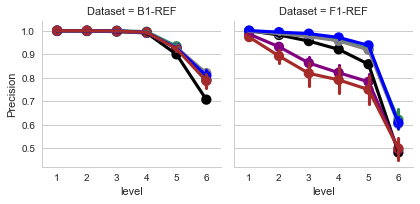

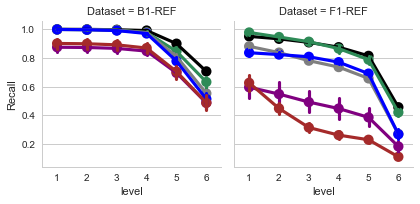

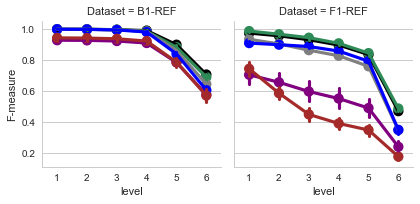

In [30]:
pointplot_from_data_frame(level_results, "level", y_vars,
                          group_by="Dataset", color_by="Method",
                          color_pallette=color_pallette)

## Per-level classification accuracy statistic
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [31]:
result = per_level_kruskal_wallis(level_results, y_vars, group_by='Method', 
                                  dataset_col='Dataset', alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Dataset   Variable             1             2             3             4  \
0  B1-REF  Precision  1.046244e-02  8.947931e-02  1.075701e-08  8.767785e-04   
1  B1-REF     Recall  9.505673e-21  2.015967e-21  7.976253e-22  1.076308e-19   
2  B1-REF  F-measure  2.015967e-21  6.158010e-22  6.856950e-23  3.545168e-20   
3  F1-REF  Precision  2.093956e-30  8.656764e-29  1.154798e-32  1.101442e-25   
4  F1-REF     Recall  1.455581e-28  6.760908e-34  1.165319e-34  1.427776e-35   
5  F1-REF  F-measure  5.122505e-29  3.397345e-34  1.427776e-35  2.435014e-36   

              5             6  
0  3.641516e-02  3.490284e-04  
1  7.645483e-11  3.880232e-07  
2  2.247364e-13  2.512670e-09  
3  5.649982e-20  1.891162e-12  
4  3.610675e-36  4.589334e-24  
5  5.604286e-38  1.455581e-28

## Heatmaps of method accuracy by parameter
Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database (i.e., for bacterial and fungal simulated datasets individually).

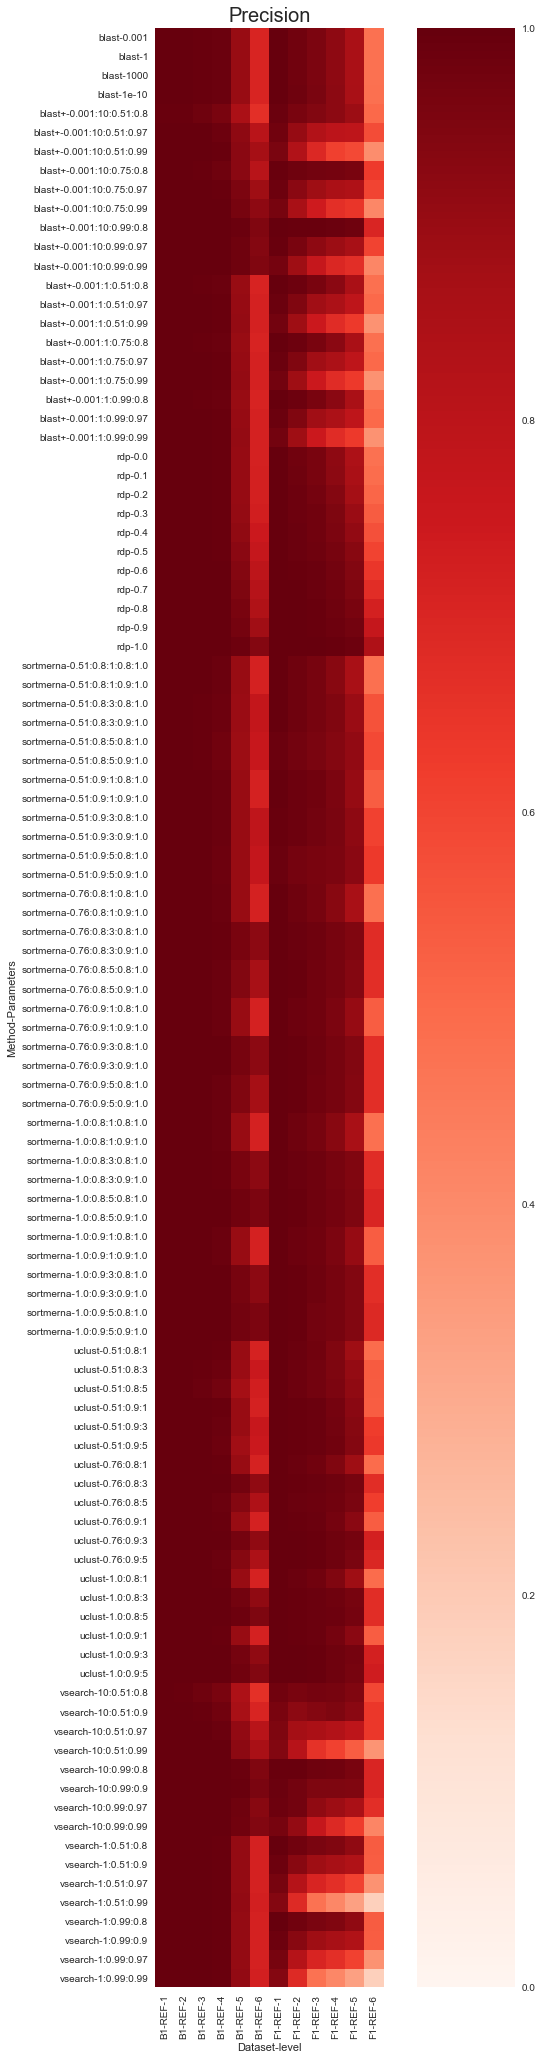

In [32]:
heatmap_from_data_frame(level_results, metric="Precision", rows=["Method", "Parameters"], cols=["Dataset", "level"])

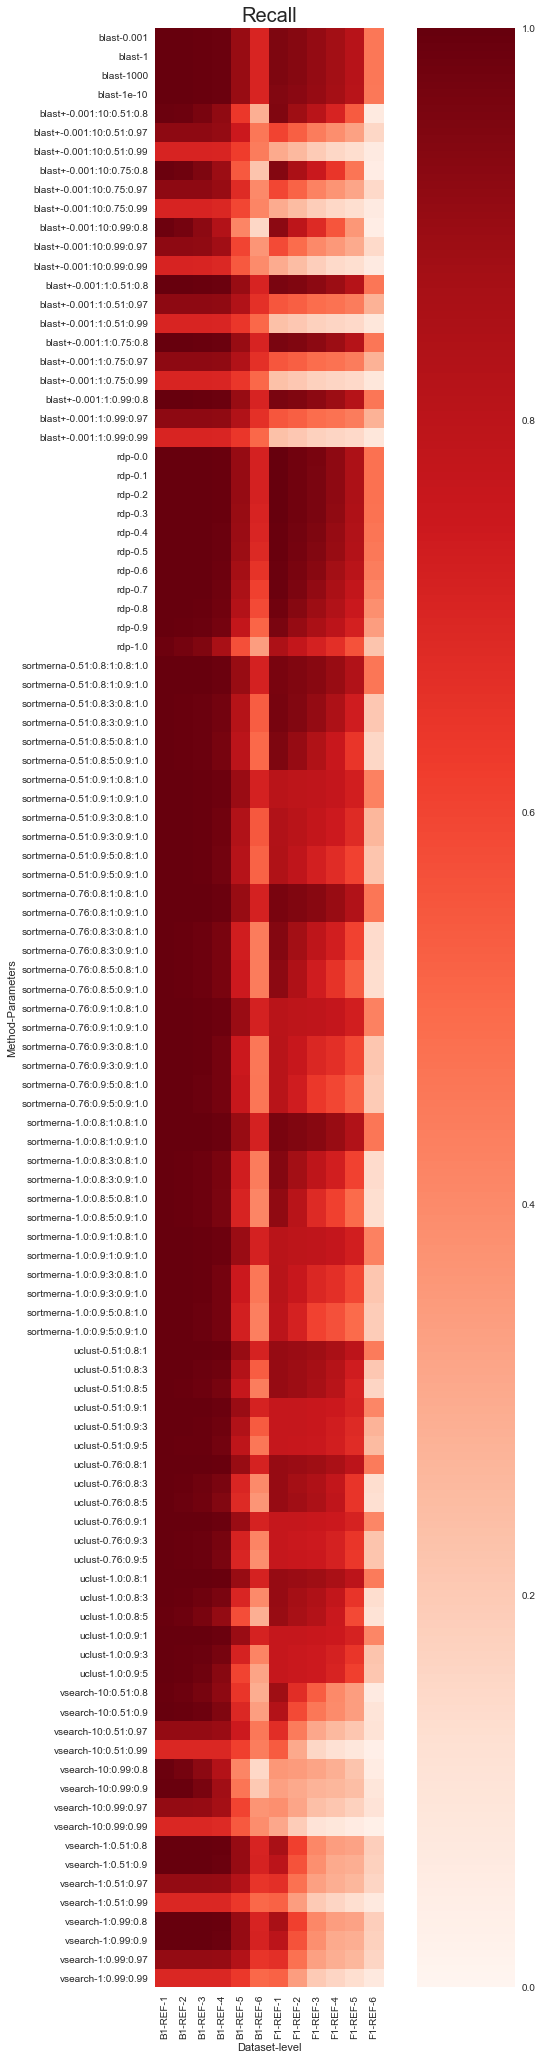

In [33]:
heatmap_from_data_frame(level_results, metric="Recall", rows=["Method", "Parameters"], cols=["Dataset", "level"])

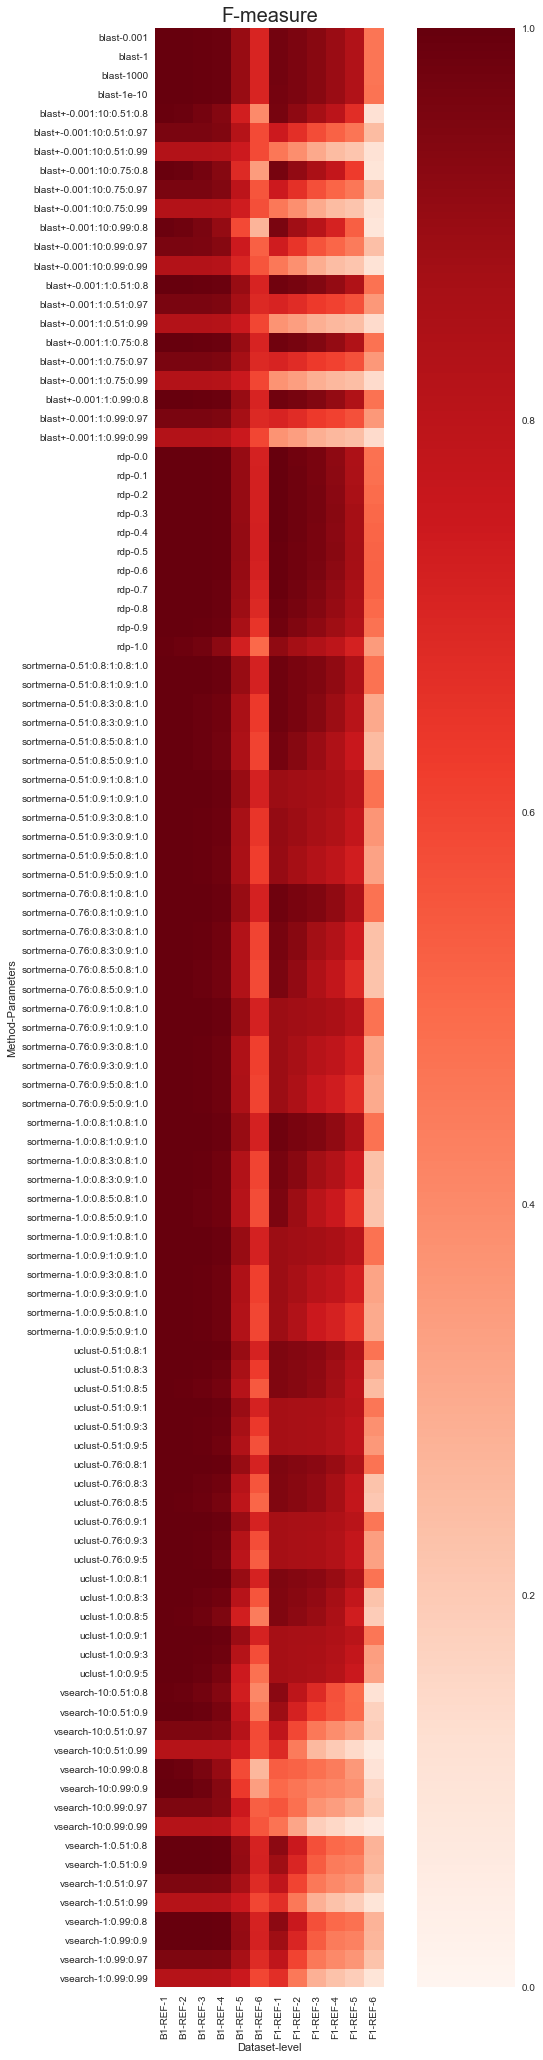

In [34]:
heatmap_from_data_frame(level_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Dataset", "level"])

## Rank-based statistics comparing the performance of the optimal parameter setting run for each method on each data set.
Rank parameters for each method to determine the best parameter configuration within each method. *Count best* values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [35]:
for method in level_results['Method'].unique():
    top_params = parameter_comparisons(level_results, method, metrics=y_vars, 
                                       sample_col='Dataset', method_col='Method',
                                       dataset_col='Dataset')
    display(Markdown('## {0}'.format(method)))
    display(top_params[:10])

## blast

F-measure  Precision  Recall
0.001         24         24      24
1             24         24      24
1000          24         24      24
1e-10         24         25      24

## blast+

F-measure  Precision  Recall
0.001:1:0.51:0.8         30.0         25    30.0
0.001:1:0.75:0.8         30.0         25    30.0
0.001:1:0.99:0.8         30.0         25    30.0
0.001:10:0.51:0.8        24.0         27    22.0
0.001:10:0.75:0.8        24.0         27    21.0
0.001:10:0.99:0.8        21.0         32    16.0
0.001:10:0.75:0.97       13.0         27    12.0
0.001:10:0.99:0.97       13.0         31    12.0
0.001:10:0.51:0.97       13.0         18    12.0
0.001:1:0.51:0.97        12.0         23    13.0

## rdp

F-measure  Precision  Recall
0.5         29         28      26
0.6         27         29      25
0.1         26         24      28
0.2         26         24      28
0.3         26         25      27
0.4         26         27      27
0.0         25         24      28
0.7         25         29      23
0.8         24         30      22
0.9         24         30      20

## sortmerna

F-measure  Precision  Recall
0.51:0.8:1:0.8:1.0         28         24      30
0.76:0.8:1:0.8:1.0         28         24      30
1.0:0.8:1:0.9:1.0          28         24      30
1.0:0.8:1:0.8:1.0          28         24      30
0.51:0.8:1:0.9:1.0         28         24      30
0.76:0.8:1:0.9:1.0         28         24      30
1.0:0.9:1:0.9:1.0          27         26      18
1.0:0.9:1:0.8:1.0          27         26      18
0.76:0.9:1:0.9:1.0         27         26      18
0.76:0.9:1:0.8:1.0         27         26      18

## uclust

F-measure  Precision  Recall
0.51:0.8:1         30         25      30
0.76:0.8:1         30         25      30
1.0:0.8:1          30         25      30
1.0:0.9:1          27         27      22
0.76:0.9:1         27         27      22
0.51:0.9:1         27         27      22
0.51:0.8:3         26         26      25
0.51:0.9:3         25         27      20
0.51:0.8:5         25         27      24
0.51:0.9:5         24         27      18

## vsearch

F-measure  Precision  Recall
1:0.51:0.8         19.0         27    18.0
1:0.99:0.8         19.0         27    18.0
10:0.51:0.8        18.0         27    15.0
1:0.51:0.9         18.0         25    18.0
1:0.99:0.9         18.0         25    18.0
1:0.51:0.97        16.0         16    13.0
1:0.99:0.97        16.0         16    13.0
10:0.51:0.9        15.0         27    15.0
10:0.51:0.97       15.0         25    12.0
10:0.99:0.8        12.0         32    10.0

## Rank performance of optimized methods
Now we rank the top-performing method/parameter combination for each method at genus and species levels. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the *metric* used for sorting best methods and for plotting.

## B1-REF level 6

Method          Parameters  Precision    Recall  F-measure
2        rdp                 0.5   0.768803  0.688224   0.726264
3  sortmerna  0.51:0.8:1:0.8:1.0   0.716966  0.716966   0.716966
5    vsearch          1:0.51:0.9   0.718555  0.711366   0.714934
4     uclust          0.76:0.9:1   0.716053  0.713440   0.714742
1     blast+    0.001:1:0.51:0.8   0.707120  0.707120   0.707120
0      blast               0.001   0.706130  0.706130   0.706130

Method A   Method B         P
0       blast     blast+  0.994042
1       blast        rdp  0.325489
2       blast  sortmerna  0.913898
3       blast     uclust  0.975023
4       blast    vsearch  0.913898
5      blast+        rdp  0.623699
6      blast+  sortmerna  0.763053
7      blast+     uclust  0.975023
8      blast+    vsearch  0.962467
9         rdp  sortmerna  0.975023
10        rdp     uclust  0.955567
11        rdp    vsearch  0.389211
12  sortmerna     uclust  0.996997
13  sortmerna    vsearch  0.996997
14     uclust    vsearch  0.996997

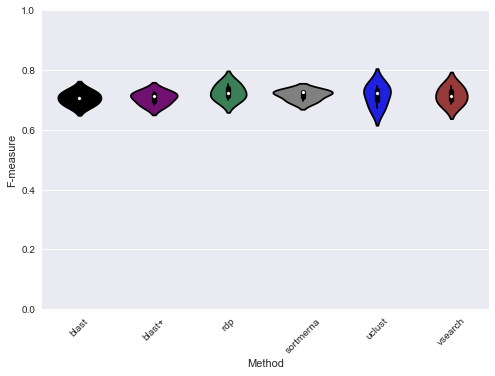

## F1-REF level 6

Method          Parameters  Precision    Recall  F-measure
2        rdp                 0.6   0.641409  0.437584   0.520174
3  sortmerna  0.76:0.9:1:0.8:1.0   0.532502  0.429327   0.475340
1     blast+    0.001:1:0.51:0.8   0.483558  0.464441   0.473801
0      blast               1e-10   0.483897  0.456713   0.469903
4     uclust          0.51:0.8:1   0.494443  0.446836   0.469426
5    vsearch          1:0.51:0.8   0.536621  0.186967   0.277123

Method A   Method B         P
0       blast     blast+  0.704974
1       blast        rdp  0.178915
2       blast  sortmerna  0.110062
3       blast     uclust  0.896701
4       blast    vsearch  0.065497
5      blast+        rdp  0.231196
6      blast+  sortmerna  0.760483
7      blast+     uclust  0.704974
8      blast+    vsearch  0.057136
9         rdp  sortmerna  0.197086
10        rdp     uclust  0.188898
11        rdp    vsearch  0.065497
12  sortmerna     uclust  0.652521
13  sortmerna    vsearch  0.063139
14     uclust    vsearch  0.053243

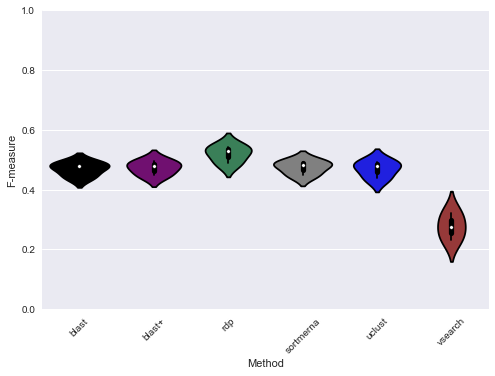

In [6]:
rank_optimized_method_performance_by_dataset(level_results,
                                             metric="F-measure",
                                             level="level",
                                             level_range=range(6,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Precision",
                                                             "Recall",
                                                             "F-measure"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)